In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celluloid
import sklearn.datasets as ds

In [2]:
NEWAXIS = np.newaxis

In [3]:
plt.style.use("ggplot")

In [4]:
X, y = ds.make_moons(16**2, 2, noise=0.2)
n_examples, n_features = X.shape
n_examples, n_features

(256, 2)

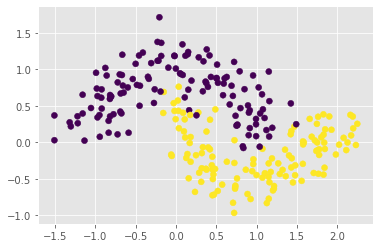

In [5]:
plt.scatter(X[:,0],X[:,1],c=y)

In [6]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-(Z)))
sigmoid_forward = sigmoid
def sigmoid_backward(Z):
    return sigmoid(Z) * (1-sigmoid(Z))
    
def relu_forward(Z):
    Z[Z<0] = 0
    return Z
def relu_backward(Z):
    return 0<Z

Recall,
$$a=\sigma(z)$$
$$z=wx+b$$

To calculate the gradient, we start the rate of change of the loss function with respect to the the final preactivation.

$$\frac{dL}{dz}=\frac{dL}{da}\times\frac{da}{dz}$$

We deal with these terms seperately.

$$
\begin{align*}
\frac{dL}{da}&=\frac{d}{da} \left[ - y \cdot log(a) - (1-y) \cdot log(1-a) \right]\\
&=\frac{-y}{a} - \frac{1-y}{1-a}\cdot(-1)\\
&=\frac{-y}{a} + \frac{1-y}{1-a}\\
&=\frac{-y(1-a)}{a(1-a)} + \frac{a(1-y)}{a(1-a)}\\
&=\frac{-y(1-a) + a(1-y)}{a(1-a)}\\
&=\frac{-y + ya + a - ya}{a(1-a)}\\
&=\frac{a-y}{a(1-a)}
\end{align*}
$$

The derivative of $a$ w.r.t. $z$ is well-known as $\sigma(z)\cdot(1-\sigma(z))$. Therefore, in all:

$$\frac{a-y}{a(1-a)}(a(1-a))=a-y$$

In [7]:
def cost_forward(y, y_pred):
    y = np.squeeze(y)
    y_pred = np.squeeze(y_pred)
    assert y.shape == y_pred.shape, (y.shape, y_pred.shape)
    return np.mean(-y*np.log(y_pred) - (1-y)*np.log(1-y_pred))
def cost_backward(y, y_pred):
    return (np.squeeze(y_pred) - np.squeeze(y))[:,NEWAXIS]

In [8]:
def intialize_weights(hidden_layer_dimensions):
    """initialize the weights and biases, as well as specify
    the activation function -- ReLu for hidden layer, sigmoid
    for the output layer"""
    weights, biases, activation_functions = [], [], []
    for i in range(len(hidden_layer_dimensions)-1):
        n_units_previous_layer = hidden_layer_dimensions[i]
        n_units_current_layer  = hidden_layer_dimensions[i+1]
        weights.append(np.random.uniform(-0.1, 0.1, (n_units_previous_layer, n_units_current_layer)))
        biases.append(np.zeros((1, n_units_current_layer)))
        activation_functions.append("relu" if i < len(hidden_layer_dimensions)-2 else "output")
    return weights, biases, activation_functions

weights, biases, activation_functions = list(intialize_weights([2,3,2,1]))
assert [w.shape for w in weights] == [(2, 3), (3, 2), (2, 1)]
assert [b.shape for b in biases] == [(1, 3), (1, 2), (1, 1)]
assert activation_functions == ['relu', 'relu', 'output']

In [52]:
weights, biases, activation_functions = list(intialize_weights([2,3,1]))

In [53]:
weights, biases, activation_functions

([array([[ 0.09924289,  0.02838067,  0.01285794],
         [ 0.08043819, -0.01524873,  0.07926073]]),
  array([[ 0.05861157],
         [-0.06261385],
         [-0.07676933]])],
 [array([[0., 0., 0.]]), array([[0.]])],
 ['relu', 'output'])

In [51]:
def forward_prop(X, weights, biases, activation_functions):
    preactivations = []
    activations    = []
    for weight, bias, activation_function in zip(weights, biases, activation_functions):
        prev_layer_activation = (X if len(activations) == 0 else activations[-1])
        preactivation = prev_layer_activation @ weight + bias
        if activation_function == "relu":
            activation = relu_forward(preactivation)
        elif activation_function == "output":
            activation = sigmoid_forward(preactivation)
        preactivations.append(preactivation)
        activations.append(activation)
    return preactivations, activations

preactivations, activations = forward_prop(X, weights, biases, activation_functions)

In [65]:
def calculate_gradients(activations,
                        preactivations,
                        weights,
                        biases,
                        activation_functions,
                        X,
                        y):
    
    assert len(activations) \
        == len(preactivations) \
        == len(activation_functions)
    
    # 𝞭s
    dpreactivations = []
    dweights = []
    dbiases = []
    cost = cost_forward(y, activations[-1])

    for i in reversed(range(len(weights))):
        in_dim, out_dim = weights[i].shape
        activation_function = activation_functions[i]
        print(f"calculating gradient for {activation_function} layer {i}: {in_dim} unit(s) -> {out_dim} unit(s)")
        if activation_function == "output":
            dpreactivation = cost_backward(y, activations[-1])
            dweight = (activations[i-1].T @ dpreactivation).mean(axis=1, keepdims=True)
        elif activation_function == "relu":
            dpreactivation = np.multiply(weights[i+1]@dpreactivations[-1], relu_backward(actionvations[i]))
            dweight = (dZ0.T@X).mean(axis=1, keepdims=True)
        else:
            raise ValueError
            
        dbias = np.mean(dpreactivation, axis=0, keepdims=True)
        print(f"=> dweight:\n{dweight}")
        print(f"=> dbias: {np.squeeze(dbias)}")
        
        dpreactivations.append(dpreactivation)
        dweights.insert(0, dweight)
        dbiases.insert(0, dbias)
    
    return dweights, dbiases, cost

In [66]:
calculate_gradients(preactivations,
                    activations,
                    weights,
                    biases,
                    activation_functions,
                    X, y)

calculating gradient for output layer 1: 3 unit(s) -> 1 unit(s)
=> dweight:
[[ -7.68854907]
 [ -0.52341585]
 [-12.91625996]]
=> dbias: -0.502038644576278
calculating gradient for relu layer 0: 2 unit(s) -> 3 unit(s)


/Users/jeremyfisher/miniconda3/envs/crunch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/jeremyfisher/miniconda3/envs/crunch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/jeremyfisher/miniconda3/envs/crunch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 256 is different from 1)

In [43]:
list(reversed(range(len(weights))))

[1, 0]

In [48]:
weights[1]

array([[-0.03909902],
       [-0.02681589],
       [-0.00929258]])

In [49]:
weights[0]

array([[ 0.05061093, -0.06994101,  0.09000444],
       [-0.04318908, -0.09782886, -0.04744091]])